### Strategy

The goal of this file is to join the **artists.csv** and **artworks.csv** datasets into one cohesive larger dataset that can be used for further analysis.

#### Notebook input: 
This notebook will read in the following:
* "data/lastnames.json"
* "data/names/"
* "data/artists.csv"
* "data/artworks.csv"

#### Notebook output:
This notebook will use the above four files to produce a dataframe stored as a csv, **data/merged.csv** 

---

We have two auxiliary datasets, a file titled **lastnames.json** and a folder titled **names/**.

The **lastnames.json** file that maps lastnames to probabilty of different ethnicities. 

The **names/** folder has a set of txt files, each repesenting most popular first names per year. The txt files when combined has a mapping of name to gender.

We will use these auxiliary datasets to augment the **artist.csv** file before joining it with the **artworks.csv** file.

---

Steps:
1. Produce consumable firstname_gender_df from **data/names/** folder
2. Produce consumable lastname_race_df from **data/lastnames.json** file
3. Produce consumable artists_df from **data/artists.csv** file
4. Join firstname_gender_df & lastname_race_df with artists_df
4. Produce consumable artworks_df from **data/artworks.csv** file
5. Join artists_df with artworks_df and write the join result as **data/merged.csv**

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### ETL for "names/" folder

Since the MoMA artist is missing a lot of data on whether an artist is M/F, we will use firstnames to judge whether or not an artist is **M** or **F**.

NOTE: Due to the unfortunate nature of our available dataset, gender is limited to binary.

In [2]:
import os
import glob

In [3]:
all_files = glob.glob(os.path.join("./data/names", "*.txt"))
names = pd.DataFrame()
for f in all_files:
    names = pd.concat([pd.read_csv(f, names=['firstname', 'gender', 'count']), names], ignore_index=False)
names.shape

(1891894, 3)

In [4]:
names.head()

,firstname,gender,count
0,Lisa,F,46081
1,Mary,F,43490
2,Susan,F,35743
3,Karen,F,35186
4,Linda,F,31462


In [5]:
grouped = names.groupby(['firstname', 'gender'])[['count']].sum().reset_index()

In [6]:
grouped_names = grouped.sort_values('count', ascending=False)
grouped_names.shape

(106695, 3)

In [7]:
grouped_names['firstname'] = grouped_names['firstname'].str.lower()
grouped_names['gender'] = grouped_names['gender'].str.lower()

In [8]:
grouped_names.head()

,firstname,gender,count
42565,james,m,5136026
47308,john,m,5105834
82496,robert,m,4809176
69398,michael,m,4338144
67099,mary,f,4120692


If there are duplicate names, drop the one with fewer count:

In [9]:
# example: drop row where 'mary' is a Male
grouped_names[grouped_names['firstname']=='mary'].head()

,firstname,gender,count
67099,mary,f,4120692
67100,mary,m,15159


In [10]:
grouped_names = grouped_names.drop_duplicates(subset='firstname', keep='first')
grouped_names.shape

(96174, 3)

In [11]:
firstname_gender_df = \
    grouped_names.drop(['count'],axis=1) \
    .reset_index(drop=True)

In [12]:
firstname_gender_df.head()

,firstname,gender
0,james,m
1,john,m
2,robert,m
3,michael,m
4,mary,f


### ETL for "lastnames_2010.json"


We'll be using the lastname.csv file to associate artists to an ethnicity.

In [13]:
raw_lastnames = pd.read_json('data/lastnames.json')

In [14]:
print(raw_lastnames.shape)
raw_lastnames.head()

(98915, 9)


,0,1,2,3,4,5,6,7,8
0,NAME,RANK,COUNT,PCTWHITE,PCTAPI,PCT2PRACE,PCTAIAN,PCTBLACK,PCTHISPANIC
1,SMITH,1,2442977,70.9,0.5,2.19,0.89,23.11,2.4
2,JOHNSON,2,1932812,58.97,0.54,2.56,0.94,34.63,2.36
3,WILLIAMS,3,1625252,45.75,0.46,2.81,0.82,47.68,2.49
4,BROWN,4,1437026,57.95,0.51,2.55,0.87,35.6,2.52


In [15]:
# actual column headers are on row 1
columns = raw_lastnames.iloc[0]

In [16]:
# skip first and last row
lastnames = raw_lastnames.iloc[1:-1]

For convinience, lets rename our columns in the following way:

| Original | Updated | Full Definition (by Census Data API) |
| :------- | :------ | :-------------- |
| NAME | lastname | Lastname/Surname |
| RANK | rank | National Rank in popularity |
| COUNT | count | Frequency: number of occurences nationally |
| PCTWHITE | white | Percent Non-Hispanic White Alone |
| PCTAPI | asian | Percent Non-Hispanic Asian and Native Hawaiian and Other Pacific Islander Alone |
| PCT2PRACE | mix | Percent Non-Hispanic Two or More Races |
| PCTAIAN | aian | Percent Non-Hispanic American Indian and Alaska Native Alone |
| PCTBLACK | black | Percent Non-Hispanic Black or African American Alone |
| PCTHISPANIC | hispanic | Percent Hispanic or Latino origin |

In [17]:
lastnames.columns = ['lastname', 'rank', 'count', 'white', 'asian', 'mix', 'aian', 'black', 'hispanic']

In [18]:
lastnames.tail()

,lastname,rank,count,white,asian,mix,aian,black,hispanic
98909,ERDRICH,160975,100,74,0,5,12,0,9
98910,EGUES,160975,100,6,(S),0,0,(S),93
98911,DOTAN,160975,100,88,(S),(S),0,0,8
98912,DIONIZIO,160975,100,92,0,(S),0,(S),7
98913,DONLEA,160975,100,94,0,0,0,0,6


Lets reshape the dataframe to be a mapping of last name to most probably ethnicity

In [19]:
def getMostLikelyRace(row):
    races = ['white', 'black', 'asian', 'aian', 'mix', 'hispanic']
    highest_probability = 0
    most_likely_race = None
    
    for race in races:
        try:
            row[race] = float(row[race])
        except ValueError:
            row[race] = 0
            
        if row[race] > highest_probability:
            highest_probability = row[race]
            most_likely_race = race
            
    return most_likely_race
    
lastnames['race'] = lastnames.apply(getMostLikelyRace, axis=1)

In [20]:
# make lastnames lowercase
lastnames['lastname'] = lastnames['lastname'].str.lower()

In [21]:
lastname_race_df = lastnames[['lastname', 'race']]

In [22]:
lastname_race_df.head()

,lastname,race
1,smith,white
2,johnson,white
3,williams,black
4,brown,white
5,jones,white


### ETL for "artists.csv"

In [23]:
artists = pd.read_csv("data/artists.csv")
artists.columns = ['artist_id', 'fullname', 'nationality', 'gender', 'birth_year', 'death_year']

print(artists.shape)
artists.head(10)

(15091, 6)


,artist_id,fullname,nationality,gender,birth_year,death_year
0,1,Robert Arneson,American,Male,1930.0,1992.0
1,2,Doroteo Arnaiz,Spanish,Male,1936.0,NaN
2,3,Bill Arnold,American,Male,1941.0,NaN
3,4,Charles Arnoldi,American,Male,1946.0,NaN
4,5,Per Arnoldi,Danish,Male,1941.0,NaN
5,6,Danilo Aroldi,Italian,Male,1925.0,NaN
6,7,Bill Aron,American,Male,1941.0,NaN
7,9,David Aronson,American,Male,1923.0,NaN
8,10,Irene Aronson,American,Female,1918.0,NaN
9,11,Jean (Hans) Arp,French,Male,1886.0,1966.0


In [24]:
def m_or_f(gender):
    if gender == "Male" or gender == "male":
        return 'm'
    elif gender == "Female" or gender == "female":
        return 'f'
    else:
        return gender
    
artists['gender'] = artists['gender'].map(m_or_f)

In [25]:
# lower case columns
artists['fullname'] = artists['fullname'].str.lower()
artists['gender'] = artists['gender'].str.lower()
artists['nationality'] = artists['nationality'].str.lower()

In [26]:
artists_df = artists

In [27]:
artists_df.head()

,artist_id,fullname,nationality,gender,birth_year,death_year
0,1,robert arneson,american,m,1930.0,1992.0
1,2,doroteo arnaiz,spanish,m,1936.0,NaN
2,3,bill arnold,american,m,1941.0,NaN
3,4,charles arnoldi,american,m,1946.0,NaN
4,5,per arnoldi,danish,m,1941.0,NaN


### Join artists_df with lastname_race_df

In [28]:
# set last name to index for quick look up
lastname_race_df = lastname_race_df.set_index('lastname', drop=True)

In [29]:
def merge_lastname_race_df(name):
    if name is None or len(name) <= 1:
        return None

    split_array = name.rsplit(' ', 1)
    last = split_array[len(split_array)-1]
    remaining = None

    if len(split_array) > 1:
        remaining = split_array[0]

    try:
        return lastname_race_df.loc[last].race
    except Exception as e:
        return merge_lastname_race_df(remaining)

artists_df['race'] = artists_df['fullname'].apply(merge_lastname_race_df)

In [30]:
artists_df.head()

,artist_id,fullname,nationality,gender,birth_year,death_year,race
0,1,robert arneson,american,m,1930.0,1992.0,white
1,2,doroteo arnaiz,spanish,m,1936.0,NaN,hispanic
2,3,bill arnold,american,m,1941.0,NaN,white
3,4,charles arnoldi,american,m,1946.0,NaN,white
4,5,per arnoldi,danish,m,1941.0,NaN,white


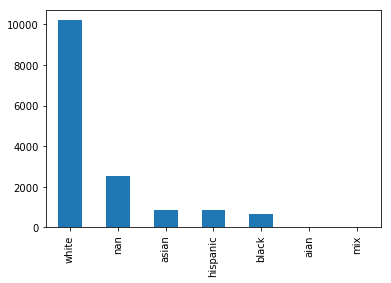

In [31]:
artists_df['race'].value_counts(dropna=False).plot(kind='bar')

#### lastname_race_df and artists_df join results:
Over 2000 artists could not be associated with a race/ethnicity. 

This command can be used to view the rows where race could not be found
```python
artists_df[pd.isnull(artists_df['race'])]
```

I think there are likely two reasons that certain rows could not be associated with a race/ethnicity. 
1. The artist is an artist group, and so no results would have matched
2. The artist is of a non-american nationality - given that the census data with the mapping of lastnames to race/ethnicity was of US born persons, it is likely that the names couldn't match because they are names not common or not seen in the US.

Hence, we must be aware of the bias of this join. If we assume that the proportion of white-to-non-white in the US is significantly larger than the proportion of white-to-non-white in the world-minus-the-US, then the 2nd of the above two reasons will mean that the a large proportion of the **NaN** are non-white artists.

### Join artists_df with firstname_gender_df

In [32]:
# set first name to index for quick look up
firstname_gender_df = firstname_gender_df.set_index('firstname', drop=True)

In [33]:
# check how many nan values there currently are in the gender column
artists_df['gender'].value_counts(dropna=False)

m      9826
NaN    3072
f      2193
Name: gender, dtype: int64

In [34]:
def merge_firstname_gender_df(name, checkOriginal):
    
    if checkOriginal:
        condition = (artists_df['fullname'] == name)
        if artists_df[condition]['gender'].iloc[0] is not np.nan:
            return artists_df[condition]['gender'].iloc[0]
        
    if name is None or len(name) <= 1:
        return None

    split_array = name.split(' ', 1)
    first = split_array[0]
    remaining = None

    if len(split_array) > 1:
        remaining = split_array[1]

    try:
        return firstname_gender_df.loc[first].gender
    except Exception as e:
        return merge_firstname_gender_df(remaining, False)

artists_df['gender'] = artists_df['fullname'] \
        .apply(lambda x: merge_firstname_gender_df(x, True))

m      11078
f       2900
NaN     1113
Name: gender, dtype: int64


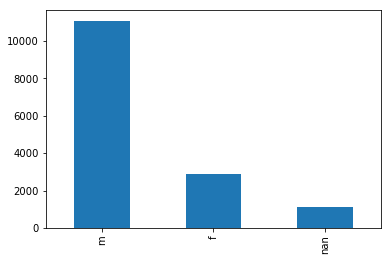

In [35]:
print(artists_df['gender'].value_counts(dropna=False))
artists_df['gender'].value_counts(dropna=False).plot(kind='bar')

#### firstname_gender_df and artists_df join results:
After joining our artist data with our firstname_gender_df data, the number of **NaN** genders reduced from 2193 to 1113.

### Finalize artists_df:

For this exercise, we're primarily interested in looking at how nationality, gender and race plays into the MoMA's collection. To reduce there data, I will remove the **birth_year** and **death_year** columns.

In [36]:
artists_df = artists_df.drop(['birth_year', 'death_year'], axis=1)

In [37]:
artists_df.head()

,artist_id,fullname,nationality,gender,race
0,1,robert arneson,american,m,white
1,2,doroteo arnaiz,spanish,m,hispanic
2,3,bill arnold,american,m,white
3,4,charles arnoldi,american,m,white
4,5,per arnoldi,danish,m,white


### Join artists and artworks dataset:

In [38]:
artworks = pd.read_csv("data/artworks.csv")

In [39]:
print(artworks.shape)
artworks.head()

(130262, 21)


,Artwork ID,Title,Artist ID,Name,Date,Medium,Dimensions,Acquisition Date,Credit,Catalogue,...,Classification,Object Number,Diameter (cm),Circumference (cm),Height (cm),Length (cm),Width (cm),Depth (cm),Weight (kg),Duration (s)
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,885.1996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,1.1995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,1.1997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,Architecture,2.1995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,2.1997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN


Lets rename the column names for convenience:

| Original | New |
| :------- | :-- |
| Artwork ID | artwork_id |
| Title | title |
| Artists ID | artist_id |
| Name | name |
| Date | creation_date |
| Medium | medium |
| Dimensions | dimensions |
| Acquisition Date | acquisition_date |
| Credit | credit |
| Catalogue | catalogue | 
| Department | department |
| Classification | classification |
| Object Number | object_number |
| Diameter (cm) | diameter | 
| Circumference (cm) | circumference |
| Height (cm) | height |
| Length (cm) | length | 
| Width (cm) | width | 
| Depth (cm) | depth |
| Weight (kg) | weight |
| Duration (s) | duration |

In [40]:
artworks.columns = ['artwork_id', 'title', 'artist_id', 'name', 'creation_date', 'medium', 'dimensions', 'acquisition_date', 'credit', 'catalogue', 'department', 'classification', 'object_number', 'diameter', 'circumference', 'height', 'length', 'width', 'depth', 'weight', 'duration']

It looks like we can have multiple artists_ids per row. For now, lets just pick the first in the list.

In [41]:
# change dtype of artist_id to int
artworks['artist_id'] = artworks['artist_id'].apply(lambda x: str(x).split(',')[0])

In [42]:
artworks.head()

,artwork_id,title,artist_id,name,creation_date,medium,dimensions,acquisition_date,credit,catalogue,...,classification,object_number,diameter,circumference,height,length,width,depth,weight,duration
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,885.1996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,1.1995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,1.1997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,Architecture,2.1995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,2.1997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN


#### Remove rows where *Date* or *Acquisition Date* is invalid

In [43]:
# drop rows where 'Date' is NaN
artworks = artworks.dropna(subset=['creation_date'])
artworks.shape

(127954, 21)

In [44]:
# for values in 'Date', if there is a year, choose the first occurance of the year, else, drop the row
import re
artworks['creation_date'] = artworks['creation_date'] \
    .map(lambda x: int(re.search('[1-2][0-9][0-9][0-9]', x).group(0)) if re.search('[1-2][0-9][0-9][0-9]', x) else None)
artworks = artworks.dropna(subset=['creation_date'])
artworks.shape

(126811, 21)

In [45]:
# drop rows where 'Acquisition Date' is NaN
artworks = artworks.dropna(subset=['acquisition_date'])
artworks.shape

(121475, 21)

In [46]:
# drop rows where 'artist_id' is NaN
artworks = artworks.drop(artworks[artworks['artist_id'].astype(str) == 'nan'].index)
artworks.shape

(120665, 21)

In [47]:
artworks_df = artworks
artworks_df.head()

,artwork_id,title,artist_id,name,creation_date,medium,dimensions,acquisition_date,credit,catalogue,...,classification,object_number,diameter,circumference,height,length,width,depth,weight,duration
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896.0,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,Architecture,885.1996,NaN,NaN,48.6000,NaN,168.9000,NaN,NaN,NaN
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987.0,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,Architecture,1.1995,NaN,NaN,40.6401,NaN,29.8451,NaN,NaN,NaN
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903.0,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,1.1997,NaN,NaN,34.3000,NaN,31.8000,NaN,NaN,NaN
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980.0,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,Architecture,2.1995,NaN,NaN,50.8000,NaN,50.8000,NaN,NaN,NaN
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903.0,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,Architecture,2.1997,NaN,NaN,38.4000,NaN,19.1000,NaN,NaN,NaN


Join **artworks_df** with **artists_df** on **artist_id**

In [48]:
artworks_df['artist_id'] = artworks_df['artist_id'].astype(int)

In [49]:
merged = pd.merge(artworks_df, artists_df, how='left', on=['artist_id'])

In [50]:
merged.head()

,artwork_id,title,artist_id,name,creation_date,medium,dimensions,acquisition_date,credit,catalogue,...,height,length,width,depth,weight,duration,fullname,nationality,gender,race
0,2,"Ferdinandsbrücke Project, Vienna, Austria, Ele...",6210,Otto Wagner,1896.0,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",1996-04-09,Fractional and promised gift of Jo Carole and ...,Y,...,48.6000,NaN,168.9000,NaN,NaN,NaN,otto wagner,austrian,m,white
1,3,"City of Music, National Superior Conservatory ...",7470,Christian de Portzamparc,1987.0,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",1995-01-17,Gift of the architect in honor of Lily Auchinc...,Y,...,40.6401,NaN,29.8451,NaN,NaN,NaN,christian de portzamparc,french,m,asian
2,4,"Villa near Vienna Project, Outside Vienna, Aus...",7605,Emil Hoppe,1903.0,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,34.3000,NaN,31.8000,NaN,NaN,NaN,emil hoppe,austrian,m,white
3,5,"The Manhattan Transcripts Project, New York, N...",7056,Bernard Tschumi,1980.0,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",1995-01-17,Purchase and partial gift of the architect in ...,Y,...,50.8000,NaN,50.8000,NaN,NaN,NaN,bernard tschumi,NaN,m,white
4,6,"Villa, project, outside Vienna, Austria, Exter...",7605,Emil Hoppe,1903.0,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",1997-01-15,Gift of Jo Carole and Ronald S. Lauder,Y,...,38.4000,NaN,19.1000,NaN,NaN,NaN,emil hoppe,austrian,m,white


In [51]:
merged.to_csv("./data/merged.csv")